In [1]:
# 導入所需的函式庫
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from tqdm import tqdm 
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
print('Tensorflow   :', tf.__version__)

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img



Tensorflow   : 2.7.0


In [2]:
# 設置一些參數
IMG_WIDTH = 1280
IMG_HEIGHT = 720
IMG_CHANNELS = 3
TRAIN_PATH = './input/train/'
TEST_PATH = './input/test/'
WEIGHT_FILE = 'model-river-land-forest.h5'


In [3]:
# 獲取並調整訓練圖像和遮罩的大小
def get_data(path, train=True):
    ids = next(os.walk(path + "/images/"))[2]
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32) # 修改類別為3
    print('Getting and resizing images ... ')
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # 載入圖片
        img = load_img(path + '/images/' + id_, color_mode="rgb")
        x_img = img_to_array(img)
        x_img = resize(x_img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)

        fname, extension = os.path.splitext(id_)
        if extension != '.png':
            mask_id_ = fname + '.png'
        else:
            mask_id_ = id_
        # 載入遮罩
        if train:
            mask = img_to_array(load_img(path + '/masks/' + mask_id_, color_mode="rgb"))
            mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True) # 修改類別為3
        # Save images
        Red = x_img[:, :, 0]/255
        Green = x_img[:, :, 1]/255
        Blue = x_img[:, :, 2]/255

        new_img = np.stack((Red, Green, Blue), axis=2)
        X[n] = new_img    

        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(TRAIN_PATH, train=True)
print(X.shape, X.dtype, y.shape, y.dtype)

Getting and resizing images ... 


100%|██████████| 52/52 [00:21<00:00,  2.47it/s]

Done!
(52, 720, 1280, 3) float32 (52, 720, 1280, 3) float32


In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2021)

In [5]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(44, 720, 1280, 3) (8, 720, 1280, 3) (44, 720, 1280, 3) (8, 720, 1280, 3)


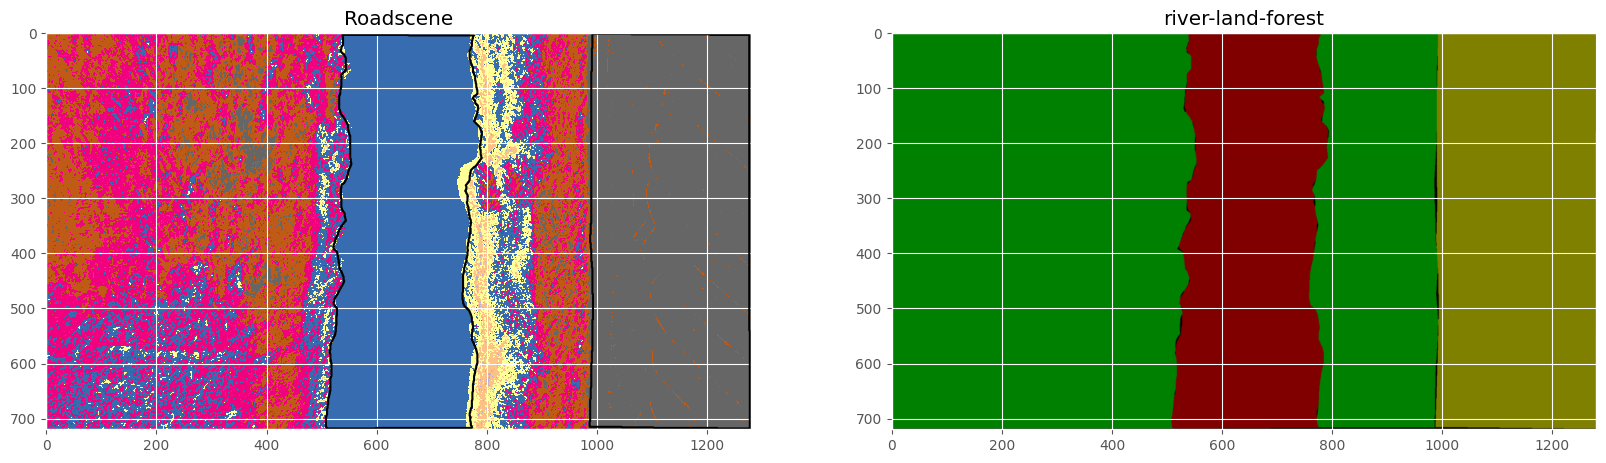

In [6]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='Accent', interpolation='bilinear')

if has_mask:
    y_train_2d = y_train[ix][:, :, 0]
ax[0].contour(y_train_2d, colors='k', levels=[0.5])
ax[0].set_title('Roadscene')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('river-land-forest');

#定義卷積層

In [7]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
    padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
    padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

#定義U-Net模型

In [8]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [9]:
input_img = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='img')

In [10]:
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

In [11]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 720, 1280,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 720, 1280, 1  448         ['img[0][0]']                    
                                6)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 720, 1280, 1  64         ['conv2d[0][0]']                 
 alization)                     6)                                                            

In [12]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-river-land-forest.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [13]:
results = model.fit(X_train, y_train, batch_size=5, epochs=300, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Epoch 1/300
9/9 [==============================] - ETA: 0s - loss: 0.6453 - accuracy: 0.5726
Epoch 00001: val_loss improved from inf to 0.83580, saving model to model-river-land-forest.h5
9/9 [==============================] - 27s 2s/step - loss: 0.6453 - accuracy: 0.5726 - val_loss: 0.8358 - val_accuracy: 0.3146 - lr: 0.0010
Epoch 2/300
9/9 [==============================] - ETA: 0s - loss: 0.5448 - accuracy: 0.8197
Epoch 00002: val_loss did not improve from 0.83580
9/9 [==============================] - 6s 640ms/step - loss: 0.5448 - accuracy: 0.8197 - val_loss: 0.9519 - val_accuracy: 0.1808 - lr: 0.0010
Epoch 3/300
9/9 [==============================] - ETA: 0s - loss: 0.4950 - accuracy: 0.9103
Epoch 00003: val_loss did not improve from 0.83580
9/9 [==============================] - 5s 603ms/step - loss: 0.4950 - accuracy: 0.9103 - val_loss: 1.4429 - val_accuracy: 0.1699 - lr: 0.0010
Epoch 4/300
9/9 [==============================] - ETA: 0s - loss: 0.4614 - accuracy: 0.9438
Epoch 0

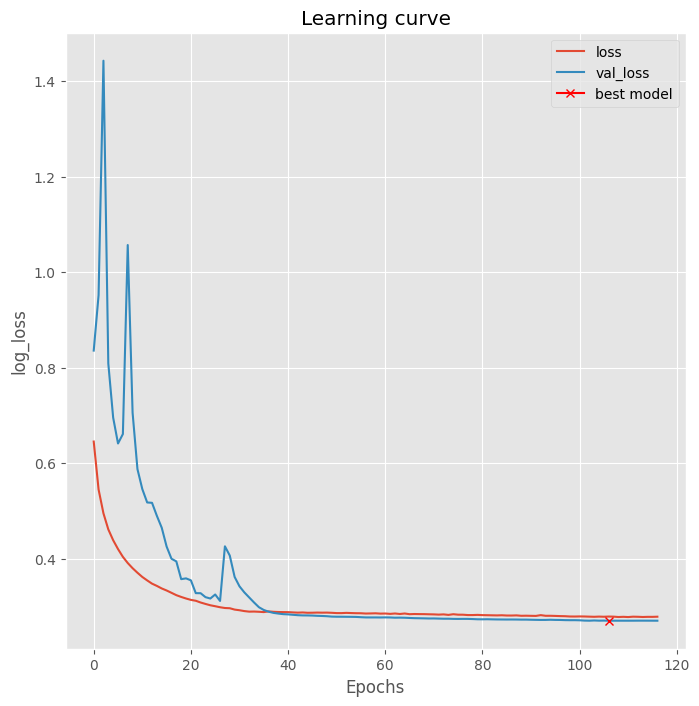

In [26]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [27]:
model.load_weights('model-river-land-forest.h5')

In [28]:
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 385ms/step - loss: 0.2701 - accuracy: 0.9282


[0.27005642652511597, 0.9281758666038513]

In [29]:
preds_train = model.predict(X_train, batch_size=5, verbose=1)
preds_val = model.predict(X_valid, batch_size=5, verbose=1)

2/2 [==============================] - 0s 156ms/step


#繪製樣本圖像

In [30]:
def plot_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    ax[0].set_title('Input Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Actual Segmentation')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Predicted Segmentation')

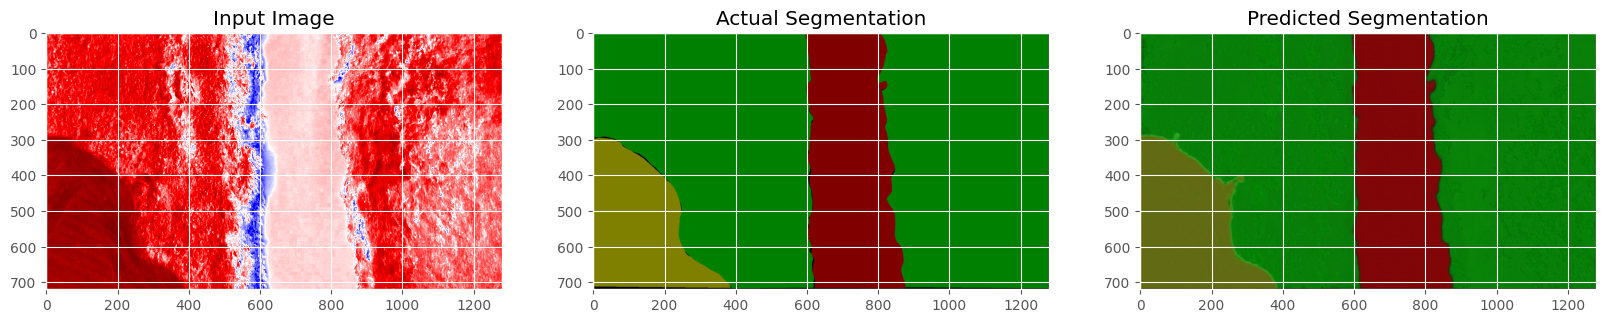

In [31]:
plot_sample(X_train, y_train, preds_train, ix=14)

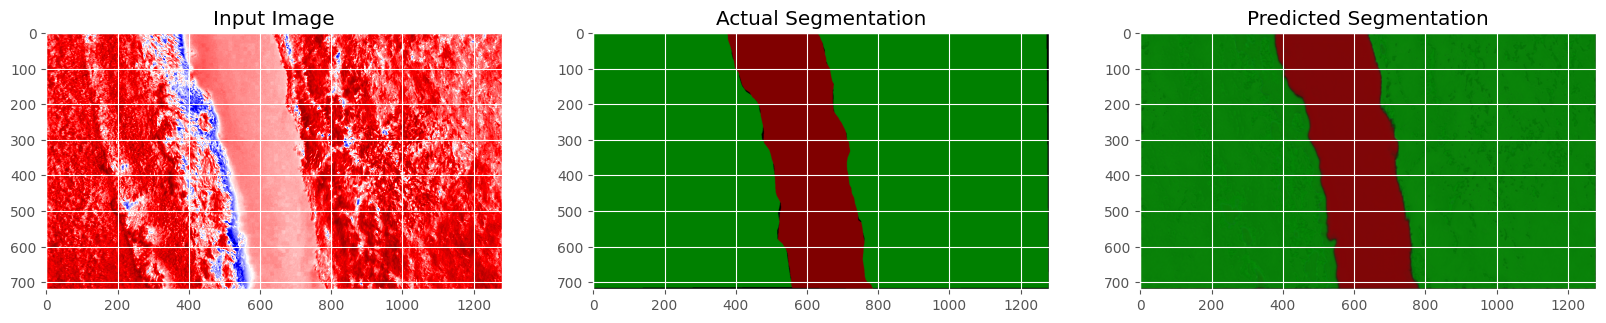

In [32]:
plot_sample(X_valid, y_valid, preds_val, ix=5)

In [33]:
X_test, y_test = get_data(TEST_PATH, train=True)

Getting and resizing images ... 


100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

Done!


In [34]:
preds_test = model.predict(X_test, batch_size =1, verbose=1)

6/6 [==============================] - 0s 53ms/step


In [35]:
model.evaluate(X_test, y_test, batch_size=8, verbose=1)

1/1 [==============================] - 0s 372ms/step - loss: 0.3013 - accuracy: 0.9121


[0.30126941204071045, 0.9120909571647644]

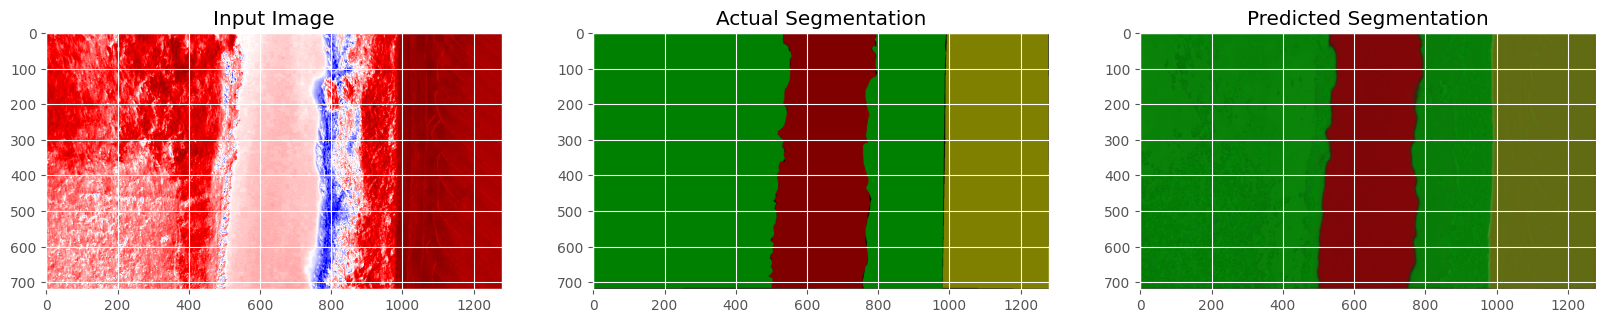

In [36]:
plot_sample(X_test, y_test, preds_test, ix=5)

#保存模型

In [37]:
tf.keras.models.save_model(model, 'model.h5')
tf.saved_model.save(model, 'saved_model')

INFO:tensorflow:Assets written to: saved_model\assets
